# Sentiment Analysis on Swiss Newspaper Jupyter Notebook

_Giorgio Bakhiet Derias_
_I3a, Bachelorarbeit_

The aim of this notebook is to show the process of creating a sentiment analysis model which reads text input and is able to attribute an emotion to it.
To train the model, I use several different datasets.

## Setup
These are the required python libraries that are used in sentiment analysis.

### Install from requirements
In order to work I first need to install the libraries from which I will then import what I need.
Since I moved my work from a Colab file to here, I created a text file called *requirements*, in which I saved all the libraries I used.
The usefulness of this file is when I move to a new environment, installing all packages at once by simply typing:

In [4]:
#%conda install --file requirements.txt

Check whether packages need updates:

In [2]:
!python -m pip install --upgrade pip

### Installing other libraries

Tensorflow packages install:

In [3]:
!pip install -q tensorflow-text

In [5]:
!pip install -q tf-models-official

Transformers package install:

In [6]:
!pip install transformers

## Imports
Once installed the packages we need we can move on to importing the various libraries that will be used during the notebook.

In [7]:
# Util
import os
import shutil
# Numpy and Pandas
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
# Tensorflow
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

# Transformers 
# Load a pre-trained BERT Tokenizer and Sequence Classifier 
# as well as InputExample and InputFeatures 
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

# Seaborn
import seaborn as sns
from pylab import rcParams
from tqdm import tqdm
# Plotly
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib import rc
# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# Data wrangling
from tidypython import gather, spread
from dplython import DplyFrame, select, sift, group_by, head, tail, arrange, summarize, mutate, X

tf.get_logger().setLevel('ERROR')

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

tf.__version__

'2.4.1'

## The Datasets
This section goes more in depth about the data set. Specifically what kind of data it contains and how it is structured.
For my work, I have been working on several datasets, so that I can later make several tests with the model, and see which dataset trains my model best.

The datasets I used:
- **"Large Movie Review Dataset v1.0"** available at https://ai.stanford.edu/~amaas/data/sentiment/
- **"Hotel reviews"** is available on kaggle:  https://www.kaggle.com/jiashenliu/515k-hotel-reviews-data-in-europe

IMDb dataset is about movie reviews, kaggle dataset is a collection of hotel reviews in europe.

## IMDb dataset
### Download and explore
First I download and extract the dataset, then I can explore the structure of the folders.
To do this I will use the utils from tensorflow and keras, which allow me to download and extract the data to the project folder.


In [8]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset_IMDB = tf.keras.utils.get_file('aclImdb_v1.tar.gz',
                                       url,
                                       untar=True,
                                       cache_dir='.',
                                       cache_subdir='')

ds_IMDB_dir = os.path.join(os.path.dirname(dataset_IMDB), 'aclImdb')

In [9]:
ds_IMDB_dir

'.\\aclImdb'

After downloading and extracting the data I check the folder structure:

In [10]:
os.listdir(ds_IMDB_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

create a folder for the train and check the folder structure again:

In [11]:
train_dir = os.path.join(ds_IMDB_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

I remove what is not useful, so that I have only the necessary data to load in the model.

In [12]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)


In [13]:
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

The folders **aclImdb/train/pos** and **aclImdb/train/neg** contains text files, each file is a review of a movie.
For example:


Positive review:

In [16]:
sample_file = os.path.join(train_dir, 'pos/16_7.txt')
with open(sample_file) as f:
    print(f.read())

I found this to be a so-so romance/drama that has a nice ending and a generally nice feel to it. It's not a Hallmark Hall Of Fame-type family film with sleeping-before-marriage considered "normal" behavior but considering it stars Jane Fonda and Robert De Niro, I would have expected a lot rougher movie, at least language-wise. <br /><br />The most memorable part of the film is the portrayal of how difficult it must be to learn how to read and write when you are already an adult. That's the big theme of the movie and it involves some touching scenes but, to be honest, the film isn't that memorable.<br /><br />It's still a fairly mild, nice tale that I would be happy to recommend.


Negative review:

In [17]:
sample_file = os.path.join(train_dir, 'neg/16_3.txt')
with open(sample_file) as f:
    print(f.read())

There are lots of extremely good-looking people in this movie. That's probably the best thing about it. Perhaps that even makes it worth watching.<br /><br />"Loaded" tells the story of Tristan Price (Jesse Metcalfe), a young man who's about to make his mark on the world. He's the son of a well-to-do family with a good reputation, and he's on his way to law school. But like so many such settings, things aren't quite as perfect as they appear. The expectations in this family far outweigh the love. Except for school, Tristan's father rarely lets him leave the house. This seems to be the result of some past traumatic event that shook the family, which is partially revealed through flashbacks but isn't spelled out until the very end. Tristan's claustrophobic environment causes him to let loose in very extreme ways at the first possible opportunity, when his friends take him out to a strip club to celebrate his graduation. The celebration soon follows some strippers back to a beach house pa

## IMDb Dataset preprocessing
We will now use the *text_dataset_from_directory* utiliy to create a labeled dataset.

**tf.data** is a tensorflow API that allows you to create complex input pipelines from simple pieces, and reuse them.

To be able to work we need to divide the dataset in test and traning, in the case of IMDb we don't need to do that because it has already been divided as we have seen in the folder structure.
What is missing, however, is a validation set, so I create a validation set using an 80/20 separation on the training data.
To do this we will use tensorflow and keras, and for the validation set we are going to change the value of the validation_split:

In [18]:
batch_size = 25000
seed = 123

In [19]:
train_imdb = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train/',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [20]:
test_imdb = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test/',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


### Convert tf obj to pandas dataframe
Now that we have the two divisions, let's work on the files preparing them for use in the BERT model.
First we will create from the two Tensorflow datasets two dataframes.

To do this we will use pandas as the code just below shows:

In [21]:
for i in train_imdb.take(1):
    train_rew = i[0].numpy()
    train_label = i[1].numpy()

In [32]:
train = pd.DataFrame([train_rew, train_label]).T
train.columns = ['Review', 'Polarity']
train['Review'] = train['Review'].str.decode("utf-8")
train.head()

,Review,Polarity
0,This film is one that played very well back in...,1
1,Matthau and Lemmon are at their very best in t...,1
2,Here's a decent mid-70's horror flick about a ...,1
3,"Oh, I heard so much good about this movie. Wen...",0
4,"""Drawing Restraint 9"" is a kind of movie one e...",0


A *polarity* of **0 means negative** sentiment for the corresponding review, while a *polarity* of **1 means positive**.

Once the training dataframe is created, I will do the same thing to create the test dataframe:


In [23]:
for i in test_imdb.take(1):
    test_rew = i[0].numpy()
    test_label = i[1].numpy()

In [33]:
test = pd.DataFrame([test_rew, test_label]).T
test.columns = ['Review', 'Polarity']
test['Review'] = test['Review'].str.decode("utf-8")
test.head()

,Review,Polarity
0,...so where's my friggin trophy? I seriously e...,0
1,This has to be the ultimate chick flick ever. ...,1
2,This is a cheap-o movie made by Al Adamson--a ...,0
3,"This version of ""The Magic Flute"" is not only ...",0
4,Brilliant and moving performances by Tom Court...,1


------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------

## Dataframe inspection

Now that we have converted the two tF obj into two pandas dataframes, we can see what these dataframes look like.

In [36]:
#see how many labeled values there are in train
train.Polarity.value_counts()

0    10057
1     9943
Name: Polarity, dtype: int64

Text(0.5, 1.0, 'Review types displayed')

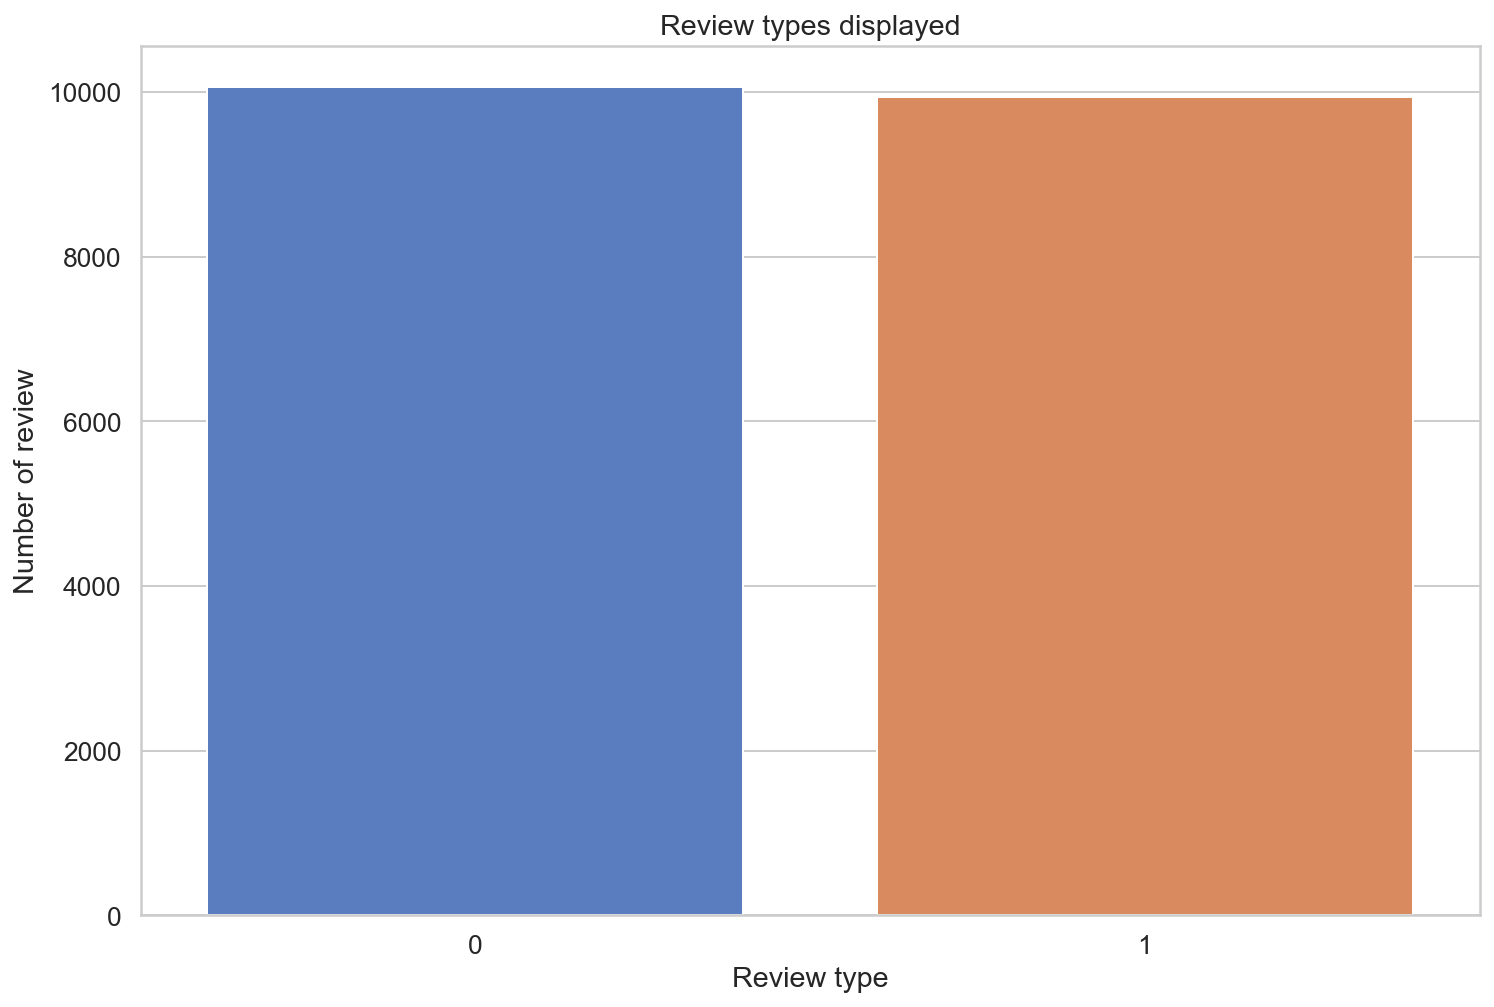

In [34]:
sns.countplot(
    x="Polarity",
    data=train,
    order=train.Polarity.value_counts().index
)

plt.xlabel("Review type")
plt.ylabel("Number of review")
plt.title("Review types displayed")

In [35]:
#see how many labeled values there are in test
test.Polarity.value_counts()

1    2557
0    2443
Name: Polarity, dtype: int64

Text(0.5, 1.0, 'Review types displayed')

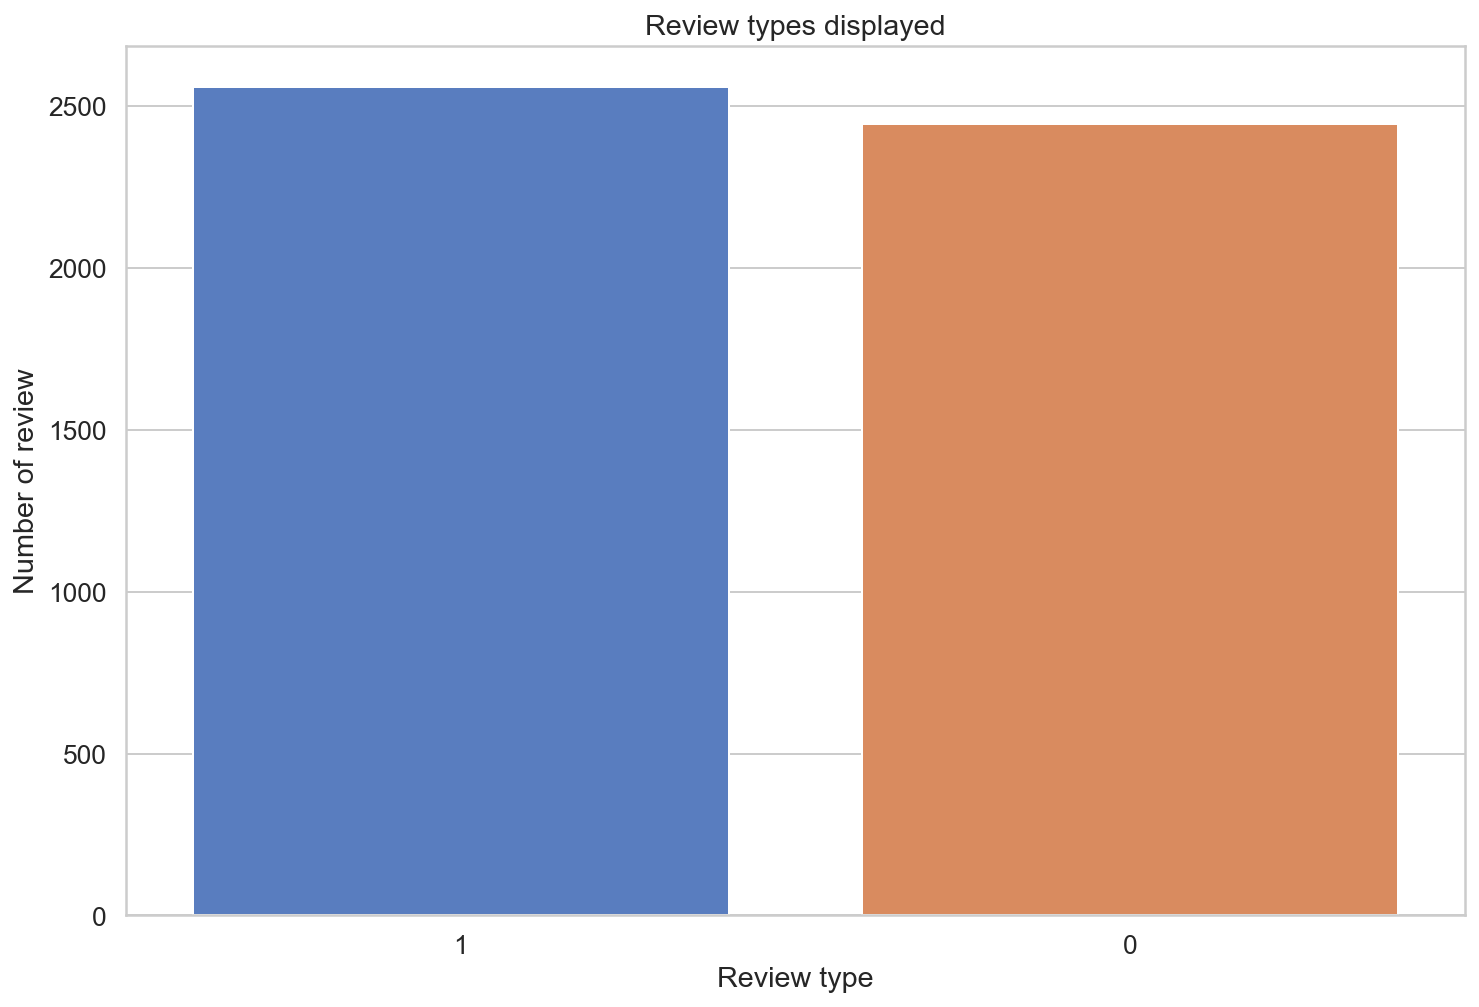

In [37]:
sns.countplot(
    x="Polarity",
    data=test,
    order=test.Polarity.value_counts().index
)

plt.xlabel("Review type")
plt.ylabel("Number of review")
plt.title("Review types displayed")


---------------------------------------------------------------------------------------------

# Sentiment Analysis

Now that we have worked on the dataframes, we can finally move on to working on the model.
To do this we must first choose how to work.

## Load the BERT Classifier and Tokenizer

For this project, I chose to work with the BERT. BERT is an acronym for Bidirectional Encoder Representations from Transformers, representing a major step forward in the Natural Language Processing (NLP) field. 
BERT is currently state of the art in the world of text classification, text summarisation, question answering and sentiment analysis.

In addition to BERT I will also use Hugging Face Transformers Library because this transformes provides thousands of pretrained models to perform most of the NLP tasks.

In this part of the project therefore I will import just from Hugging Face the BERT model and the tokenizer that, thanks to many hours of research, I found the most appropriate for the job.

The code to doing that is in the cell below:

In [43]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased") 
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The TFBertForSequnceClassification model, is a pre-trained model and takes 3 input features:
​
* **input ids**: are an id number assigned to each word based on the existing BERT vocabularies.
​
* **token type ids**: token type ids are required to differentiate between actual words and paddings, because BERT tokenizer  pad your sentence with 0 so that every sentence is of the same length.
​
* **attention masks**: recognizes which sentence a given word belongs to.
​
BERT tokenizer has a function encode_plus which converts your raw sentences into the three input features. 

I will use the smaller Bert-Base pre-trained "bert-base-uncased" for this task, which is composed as follows: 12-layer, 768-hidden, 12-heads, 110M parameters.
 
#The Bert-Base model has 12 attention layers and all text will be converted to lowercase by the tokeniser.

Let’s see the summary of the BERT model:

In [45]:
model.summary()

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_75 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


## Create sequences

I currently have two pandas dataframes, only it's better if I convert them into more "digestible" objects for my BERT model.
This is where the InputExample class comes to my assistance.

What does InputExample do? InputExample is a function that creates sequences from datasets.
To do so here is an example of how it is written:

In [ ]:
#We will use the smaller Bert-Base, uncased model for this task. The Bert-Base model has 12 attention layers and all text will be converted to lowercase by the tokeniser.

In [31]:
InputExample(guid=None,
            text_a= "Hello, world",
            text_b= None,
            label = 1)

InputExample(guid=None, text_a='Hello, world', text_b=None, label=1)

Now that I have all my ingredients I need to create the two main functions:

1. convert_data_to_inputExamples : This will accept our train and test datasets and convert each row into an InputExample object.
1. convert_inputExamples_to_tf_dataset : This function will tokenize the InputExample objects, then create the required input format with the tokenized objects, finally, create an input dataset that we can feed to the model.

In [38]:
def convert_data_to_InputExamples(train, test, Review, Polarity): #'Review', 'Polarity'
    InputExamples_train = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[Review],
                                                          text_b = None,
                                                          label = x[Polarity]), axis = 1)

    InputExamples_validation = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[Review],
                                                          text_b = None,
                                                          label = x[Polarity]), axis = 1)
  
    return InputExamples_train, InputExamples_validation

BERT tokenizer has a function encode_plus which converts your raw sentences into the three input features. The following code helps to organise your dataset in Tensors, such that it is compatible with BERT tensorflow implementation.

In [39]:
def convert_inputExamples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for padding
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


Review = 'Review'
Polarity = 'Polarity'

We can call the functions we created above like this:


In [42]:
InputExamples_train, InputExamples_validation = convert_data_to_InputExamples(train,test,'Review','Polarity')


train_data = convert_inputExamples_to_tf_dataset(list(InputExamples_train), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_inputExamples_to_tf_dataset(list(InputExamples_validation), tokenizer)
validation_data = validation_data.batch(32)

C:\Users\Admin\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2149: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


### Configuring the BERT model

In [46]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

In [47]:
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
model.fit(train_data, epochs=10, validation_data=validation_data)

Epoch 1/10


C:\Users\Admin\AppData\Local\Temp\tmp7cwfwhz5.py:8: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  ag__.converted_call(ag__.ld(warnings).warn, ("The 'warn' method is deprecated, use 'warning' instead", ag__.ld(DeprecationWarning), 2), None, fscope)


    993/Unknown - 10954s 11s/step - loss: 0.3784 - accuracy: 0.8219